In [17]:
from torchvision.models import vgg16, VGG
from inpainting.utils import mask_to_bbox
%matplotlib inline

import glob
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.models.resnet import resnet50, ResNet
from torchvision.transforms import transforms as T
from torchvision.transforms.functional import to_pil_image

from inpainting.load import VideoDataset, MergeDataset

In [18]:
input_images_dataset = VideoDataset(
    list(glob.glob(f'../data/interim/demo/ResizedJPEGImages/*')),
    'image'
)
input_masks_dataset = VideoDataset(
    list(glob.glob(f'../data/interim/demo/ResizedMasks/*')),
    'mask'
)
dataset = MergeDataset([input_images_dataset, input_masks_dataset], transform=T.ToTensor())

In [19]:
feature_extractor = resnet50(pretrained=True)

torch.Size([3, 256, 256])


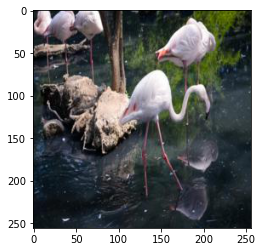

In [20]:
images, masks = dataset[1]
source_image = images[10]
print(source_image.size())
plt.imshow(to_pil_image(source_image))

torch.Size([3, 153, 104])


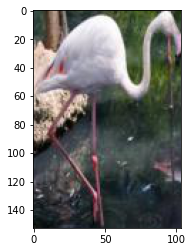

In [21]:
(x1, y1), (x2, y2) = mask_to_bbox(masks[0])
exemplar_image = images[0][:, y1:y2, x1:x2]
print(exemplar_image.size())
plt.imshow(to_pil_image(exemplar_image))

torch.Size([104, 153])


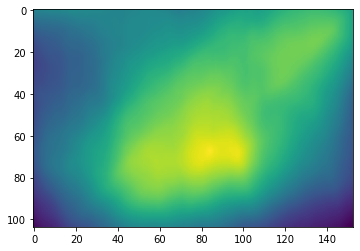

In [22]:
image_correlation = nn.functional.conv2d(source_image.unsqueeze(0), exemplar_image.unsqueeze(0)).squeeze()
image_correlation -= torch.min(image_correlation)
image_correlation /= torch.max(image_correlation)
print(image_correlation.size())
plt.imshow(to_pil_image(image_correlation))

In [23]:
def extract_features(x):
    if isinstance(feature_extractor, ResNet):
        x = feature_extractor.conv1(x)
        x = feature_extractor.bn1(x)
        x = feature_extractor.relu(x)
        x = feature_extractor.maxpool(x)

        f1 = feature_extractor.layer1(x)
        f2 = feature_extractor.layer2(f1)
        f3 = feature_extractor.layer3(f2)
        f4 = feature_extractor.layer4(f3)
    else:
        raise ValueError(feature_extractor)
    return f1, f2, f3, f4

source_features = extract_features(source_image.unsqueeze(0))
exemplar_features = extract_features(exemplar_image.unsqueeze(0))

In [24]:
def demo(s, e):
    print(s.size())
    print(e.size())
    feature_correlation = nn.functional.conv2d(s.detach(), e.detach()).squeeze()
    feature_correlation -= torch.min(feature_correlation)
    feature_correlation /= torch.max(feature_correlation)
    print(feature_correlation.size())
    plt.imshow(to_pil_image(feature_correlation))

torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 39, 26])
torch.Size([26, 39])


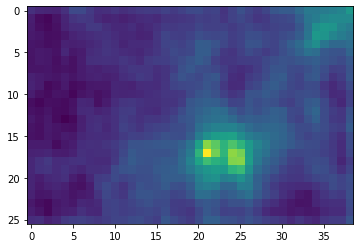

In [25]:
demo(source_features[0], exemplar_features[0])

torch.Size([1, 512, 32, 32])
torch.Size([1, 512, 20, 13])
torch.Size([13, 20])


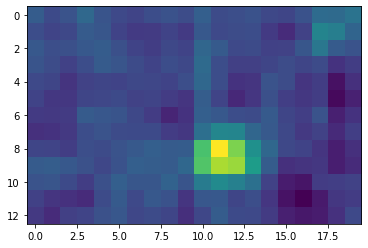

In [26]:
demo(source_features[1], exemplar_features[1])

torch.Size([1, 1024, 16, 16])
torch.Size([1, 1024, 10, 7])
torch.Size([7, 10])


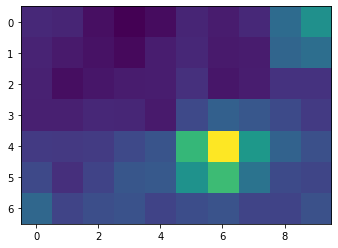

In [27]:
demo(source_features[2], exemplar_features[2])

torch.Size([1, 2048, 8, 8])
torch.Size([1, 2048, 5, 4])
torch.Size([4, 5])


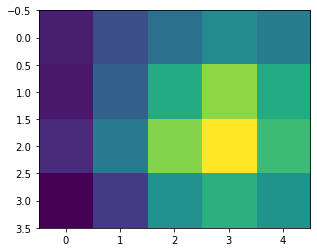

In [28]:
demo(source_features[3], exemplar_features[3])
